In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [188]:
import Parameters as p
reload(p)

<module 'Parameters' from 'Parameters.py'>

In [189]:
pipe_construction_data = pd.read_csv('C:\Users\Olga\Documents\RENUWIT\Urine_separation\python_model\\pipe_construction_data.csv')
pump_construction_data = pd.read_csv('C:\Users\Olga\Documents\RENUWIT\Urine_separation\python_model\\pump_construction_data.csv')

In [190]:
scaling_factor = 1
electricity_EF=p.electricity_EF
motor_efficiency = p.motor_efficiency
specific_weight = p.specific_weight #kN/m3
catridge_diameter = p.catridge_diameter #mm
PVC_density = p.PVC_density #g/cm3
PVC_lifetime=p.PVC_lifetime
resin_density = p.resin_density #g/L
resin_cost = p.resin_cost #$/kg
resin_energy_ef = p.resin_energy #MJ/kg ion exchange resin WEST
resin_GHG_ef = p.resin_GHG #kg/kg ion exchange resin WEST
resin_energy_MJ_kg=resin_energy_ef #MJ/kg
resin_GHG_kg_kg = resin_GHG_ef #kg/kg
hydraulic_conductivity = p.hydraulic_conductivity #m/s
resin_lifetime = p.resin_lifetime

N_urine = p.N_urine #gN/L
adsorption_density = p.adsorption_density #mmolN/g resin
molar_mass_N = p.molar_mass_N #g/mol

time_between_catridge_regeneration = p.time_between_catridge_regeneration #days
urine_production = p.urine_production #L/day-person
urine_production_scaled = urine_production/scaling_factor
household_size = p.household_size

flow_equalization_retention_time=p.flow_equalization_retention_time
steel_GHG_kg_kg=p.steel_GHG #kgCO2/kg
steel_energy_MJ_kg=p.steel_energy #MJ/kg
steel_sheet_mass=p.steel_sheet_mass #kg
steel_sheet_area = p.steel_sheet_area #m2
tank_height = p.tank_height #m
tank_thickness=p.tank_thickness #m
steel_lifetime=p.steel_lifetime

transport_energy_MJ_tonmile=p.transport_energy #MJ/ton-mile
transport_GHG_kg_tonmile=p.transport_GHG #kgCo2/ton-mile
miles=p.transport_miles

plastic_energy=p.plastic_energy #MJ/$  EIOLCA plastics manufacturing
plastic_GHG=p.plastic_GHG #kg/$ EIOLCA plastics manufacturing
plastic_cost = p.plastic_cost  #$/m3 alibaba
plastic_density = p.plastic_density #kg/m3
plastic_energy_MJ_kg = plastic_energy*plastic_cost/plastic_density
plastic_GHG_kg_kg = plastic_GHG*plastic_cost/plastic_density
plastic_lifetime = p.plastic_lifetime #years

pump_lifetime=p.pump_lifetime

sulfiric_acid_energy = p.sulfiric_acid_energy #MJ/kg Ecoinvent
sulfiric_acid_GHG = p.sulfiric_acid_GHG #kg/kg Ecoinvent

In [191]:
pipe_construction_data=pipe_construction_data[pipe_construction_data['Material']=='PVC']
nominal_diameter_list=np.array(pipe_construction_data['size_mm'])
pump_size_list=np.array(pump_construction_data['Rating_hp'])

In [192]:
def find_transport_energy(mass, lifetime):
    transport_energy = transport_energy_MJ_tonmile*miles*mass/(1000*lifetime)
    return transport_energy #MJ_y
    
def find_transport_GHG(mass,lifetime):
    transport_GHG = transport_GHG_kg_tonmile*miles*mass/(1000*lifetime)
    return transport_GHG #kg_y

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

In [193]:
class resin():
    def __init__(self,household_size):
        self.household_size=household_size
        
    def mass_resin_household(self):
        daily_urine_household = self.household_size*urine_production_scaled #L/day
        volume_urine_treated_before_replacement = time_between_catridge_regeneration*daily_urine_household #L
        mass_resin_household=volume_urine_treated_before_replacement*N_urine/(adsorption_density*molar_mass_N) #kg
        return mass_resin_household #kg
    
    def resin_energy(self):
        resin_energy = self.mass_resin_household()*resin_energy_MJ_kg/resin_lifetime
        return resin_energy #MJ_y
    
    def resin_GHG(self):
        resin_GHG = self.mass_resin_household()*resin_GHG_kg_kg/resin_lifetime
        return resin_GHG #kg_y
    
    def transportation_energy(self):
        mass_resin_household = self.mass_resin_household()
        resin_transport_energy=find_transport_energy(mass_resin_household, resin_lifetime)
        return resin_transport_energy #MJ_y
    
    def transportation_GHG(self):
        mass_resin_household = self.mass_resin_household()
        resin_transport_GHG=find_transport_GHG(mass_resin_household, resin_lifetime)
        return resin_transport_GHG #kg_y
    
    def total_energy(self):
        total_energy = self.resin_energy()+self.transportation_energy()
        return total_energy #MJ_y
    
    def total_GHG(self):
        total_GHG = self.resin_GHG()+self.transportation_GHG()
        return total_GHG #kg_y

In [194]:
class catridge():
    def __init__(self, diameter, mass_resin_household):
        self.diameter = diameter
        self.mass_resin_household = mass_resin_household
        
    def catridge_volume(self):
        catridge_volume = self.mass_resin_household/resin_density*1000 #L
        return catridge_volume
    
    def catridge_length(self):
        catridge_length = self.catridge_volume()*1000/(math.pi*((self.diameter/10)/2)**2)/100 #m
        return catridge_length
    
    def mass_PVC(self):
        diameter_mm=self.diameter
        diameter=find_nearest(nominal_diameter_list,diameter_mm)
        pipe_index=pipe_construction_data.set_index('size_mm')
        pipe_weight_kg=pipe_index.Wt_kg_m[diameter]*self.catridge_length()
        return pipe_weight_kg

    def PVC_energy(self):
        pipe_index=pipe_construction_data.set_index('size_mm')
        diameter_mm=self.diameter
        diameter=find_nearest(nominal_diameter_list,diameter_mm)
        PVC_energy_MJ=pipe_index.Embodied_Energy_MJ_kg[diameter]*self.mass_PVC()/PVC_lifetime
        return PVC_energy_MJ #MJ_y

    def PVC_GHG(self):
        pipe_index=pipe_construction_data.set_index('size_mm')
        diameter_mm=self.diameter
        diameter=find_nearest(nominal_diameter_list,diameter_mm)
        PVC_GHG_kg=pipe_index.Emissions_kgCO2_eq_m[diameter]*self.catridge_length()/PVC_lifetime
        return PVC_GHG_kg #kg_y
    
    def transportation_energy(self):
        mass_PVC = self.mass_PVC()
        PVC_transport_energy=find_transport_energy(mass_PVC, PVC_lifetime)
        return PVC_transport_energy #MJ_y
    
    def transportation_GHG(self):
        mass_PVC = self.mass_PVC()
        PVC_transport_GHG=find_transport_GHG(mass_PVC, PVC_lifetime)
        return PVC_transport_GHG #kg_y
    
    def total_energy(self):
        total_energy = self.PVC_energy()+self.transportation_energy()
        return total_energy #MJ_y
    
    def total_GHG(self):
        total_GHG = self.PVC_GHG()+self.transportation_GHG()
        return total_GHG #kg_y

In [195]:
class flow_equalization_steel():
    def __init__(self, household_size):
        self.household_size=household_size
        
    def volume(self):
        daily_urine_household = self.household_size*urine_production_scaled #L/day
        volume = daily_urine_household*flow_equalization_retention_time/1000 
        return volume #m3
    
    def area_cylinder(self):
        radius = math.sqrt(self.volume()/(math.pi*tank_height))
        area = 2*math.pi*radius*tank_height+2*math.pi*radius**2
        return area
    
    def mass_steel(self):
        area = self.area_cylinder()       
        if area/steel_sheet_area<0:
            num_steel_sheets=1
            mass_steel_sheets = num_steel_sheets*steel_sheet_mass
            mass_steel=mass_steel_sheets*(area/steel_sheet_area)
        else:
            num_steel_sheets=(area/steel_sheet_area)
            mass_steel = num_steel_sheets*steel_sheet_mass
        return mass_steel
        
    def steel_energy(self):
        mass_steel = self.mass_steel()
        steel_energy = mass_steel*steel_energy_MJ_kg/steel_lifetime
        return steel_energy #MJ_y

    def steel_GHG(self):
        mass_steel = self.mass_steel()
        steel_GHG = mass_steel*steel_GHG_kg_kg/steel_lifetime
        return steel_GHG #kg_y
    
    def transportation_energy(self):
        mass_steel = self.mass_steel()
        steel_transport_energy=find_transport_energy(mass_steel, steel_lifetime)
        return steel_transport_energy #MJ_y
    
    def transportation_GHG(self):
        mass_steel = self.mass_steel()
        steel_transport_GHG=find_transport_GHG(mass_steel, steel_lifetime)
        return steel_transport_GHG #kg_y
    
    def total_energy(self):
        total_energy = self.steel_energy()+self.transportation_energy()
        return total_energy #MJ_y
    
    def total_GHG(self):
        total_GHG = self.steel_GHG()+self.transportation_GHG()
        return total_GHG #kg_y

In [196]:
class flow_equalization_plastic():
    def __init__(self, household_size):
        self.household_size=household_size
        
    def volume(self):
        daily_urine_household = self.household_size*urine_production_scaled #L/day
        volume = daily_urine_household*flow_equalization_retention_time/1000 
        return volume #m3
    
    def area_cylinder(self):
        radius = math.sqrt(self.volume()/(math.pi*tank_height))
        area = 2*math.pi*radius*tank_height+2*math.pi*radius**2
        return area
    
    def mass_plastic(self):
        area = self.area_cylinder()       
        mass = area*tank_thickness*plastic_density
        return mass
        
    def plastic_energy(self):
        mass = self.mass_plastic()
        plastic_energy = mass*plastic_energy_MJ_kg/plastic_lifetime
        return plastic_energy #MJ_y

    def plastic_GHG(self):
        mass = self.mass_plastic()
        plastic_GHG = mass*plastic_GHG_kg_kg/plastic_lifetime
        return plastic_GHG #kg_y
    
    def transportation_energy(self):
        mass = self.mass_plastic()
        plastic_transport_energy=find_transport_energy(mass, plastic_lifetime)
        return plastic_transport_energy #MJ_y
    
    def transportation_GHG(self):
        mass = self.mass_plastic()
        plastic_transport_GHG=find_transport_GHG(mass, plastic_lifetime)
        return plastic_transport_GHG #kg_y
    
    def total_energy(self):
        total_energy = self.plastic_energy()+self.transportation_energy()
        return total_energy #MJ_y
    
    def total_GHG(self):
        total_GHG = self.plastic_GHG()+self.transportation_GHG()
        return total_GHG #kg_y

In [197]:
class pump_flow():
    def __init__(self, household_size, catridge_diameter,catridge_length):
        self.household_size=household_size
        self.catridge_diameter = catridge_diameter
        self.catridge_length = catridge_length

    def headloss(self):
        daily_urine_household = (self.household_size*urine_production_scaled)/(24*3600*1000) #m3/s
        surface_area = math.pi*(self.catridge_diameter/1000/2)**2
        headloss = daily_urine_household*self.catridge_length/(surface_area*hydraulic_conductivity)
        return headloss
    
    def pump_power(self):
        daily_urine_household = (self.household_size*urine_production_scaled)/(24*3600*1000) #m3/s
        p_hp = specific_weight*daily_urine_household*self.headloss()/(0.4*motor_efficiency)*1.34
        if p_hp<3:
            pump_efficiency=0.4
        elif 3<=p_hp<7:
            pump_efficiency=0.45
        elif 7<=p_hp<15:
            pump_efficiency=0.5
        elif 15<=p_hp<40:
            pump_efficiency=0.55
        elif 40<=p_hp<60:
            pump_efficiency=0.6
        else:
            pump_efficiency=0.7
        power = specific_weight*daily_urine_household*self.headloss()/(pump_efficiency*motor_efficiency)
        return power #KW
    
    def pump_size(self):
        size = self.pump_power()*1.34
        pump_index=pump_construction_data.set_index('Rating_hp')
        pump_size=find_nearest(pump_size_list,size)
        return pump_size
    
    def mass_pump(self):
        pump_index=pump_construction_data.set_index('Rating_hp')
        pump_size = self.pump_size()
        mass_pump=pump_index.Wt_kg[pump_size]
        return mass_pump
    
    def pump_operating_energy(self):
        energy = self.pump_power()*24*365*3.6
        return energy #MJ/y
    
    def pump_operating_GHG(self):
        GHG = self.pump_operating_energy()*electricity_EF
        return GHG #Kg/y
    
    def pump_embodied_energy(self):
        pump_index=pump_construction_data.set_index('Rating_hp')
        pump_size = self.pump_size()
        pump_energy_MJ=pump_index.Embodied_Energy_MJ[pump_size]/pump_lifetime
        return pump_energy_MJ #MJ/y
    
    def pump_embodied_GHG(self):
        pump_index=pump_construction_data.set_index('Rating_hp')
        pump_size = self.pump_size()
        pump_GHG_kg=pump_index.Emissions_kgCO_eq[pump_size]/pump_lifetime
        return pump_GHG_kg #MJ/y
        
    def transportation_energy(self):
        mass = self.mass_pump()
        pump_transport_energy=find_transport_energy(mass, pump_lifetime)
        return pump_transport_energy #MJ_y
    
    def transportation_GHG(self):
        mass = self.mass_pump()
        pump_transport_GHG=find_transport_GHG(mass, pump_lifetime)
        return pump_transport_GHG #kg_y
    
    def total_energy(self):
        total_energy = self.pump_operating_energy()+pump_embodied_energy+self.transportation_energy()
        return total_energy #MJ_y
    
    def total_GHG(self):
        total_GHG = self.pump_operating_GHG()+pump_embodied_GHG+self.transportation_GHG()
        return total_GHG #kg_y    

In [198]:
class regeneration():
    sulfiric acid
    building

IndentationError: expected an indented block (<ipython-input-198-2a72c3ac2781>, line 2)

In [ ]:
class logistics():
    trucking distance

In [209]:
Resin = resin(household_size)
resin_energy = Resin.total_energy()
resin_GHG = Resin.total_GHG()

In [210]:
Catridge=catridge(catridge_diameter,Resin.mass_resin_household())
catridge_energy = Catridge.total_energy()
catridge_GHG = Catridge.total_GHG()

In [211]:
Flow_equalization=flow_equalization_plastic(household_size)
flow_equalization_energy = Flow_equalization.total_energy()
flow_equalization_GHG = Flow_equalization.total_GHG()

In [212]:
Pump = pump_flow(household_size,Catridge.diameter,Catridge.catridge_length())
pump_energy = Resin.total_energy()
pump_GHG = Resin.total_GHG()

In [213]:
Total_ENERGY=[Resin.resin_energy(),Resin.transportation_energy(),Catridge.PVC_energy(),Catridge.transportation_energy(),Flow_equalization.plastic_energy(),Flow_equalization.transportation_energy(),Pump.pump_operating_energy(),Pump.pump_embodied_energy(),Pump.transportation_energy()]
Total_GHG=[Resin.resin_GHG(),Resin.transportation_GHG(),Catridge.PVC_GHG(),Catridge.transportation_GHG(),Flow_equalization.plastic_GHG(),Flow_equalization.transportation_GHG(),Pump.pump_operating_GHG(),Pump.pump_embodied_GHG(),Pump.transportation_GHG()]


In [214]:
Total_ENERGY=pd.DataFrame(Total_ENERGY)
Total_ENERGY = Total_ENERGY/(household_size*urine_production_scaled*365)
Total_ENERGY_plot=Total_ENERGY.transpose()
Total_GHG=pd.DataFrame(Total_GHG)
Total_GHG=Total_GHG/(household_size*urine_production_scaled*365)
Total_GHG_plot=Total_GHG.transpose()
Total_ENERGY_plot.columns=['Resin manufacturing','Resin transport', 'Catridge manufacturing', 'Catridge transport', 'Tank manufacturing', 'Tank transport', 'Pump operation', 'Pump manufacturing', 'Pump transport']
Total_GHG_plot.columns=['Resin manufacturing','Resin transport', 'Catridge manufacturing', 'Catridge transport', 'Tank manufacturing', 'Tank transport', 'Pump operation', 'Pump manufacturing', 'Pump transport']


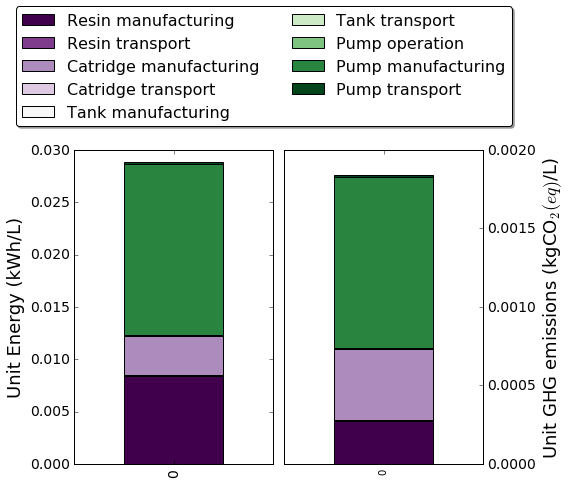

In [215]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1,2, 1)
a=Total_ENERGY_plot.plot(kind='bar', stacked = True, ax=ax, legend=False,colormap='PRGn')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Unit Energy (kWh/L)',fontsize=18)
ax = fig.add_subplot(1,2, 2)
b=Total_GHG_plot.plot(kind='bar', stacked = True, secondary_y=True, ax=ax, legend=False,colormap='PRGn')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Unit GHG emissions (kgCO$_2(eq)$/L)',fontsize=18)
b.legend(loc='lower center', bbox_to_anchor=(-0.1, 1.05),ncol=2, fancybox=True, shadow=True,fontsize=16)
fig.tight_layout()